<div style='text-align:center'>
    <h1> ========== COS710 - Assignment 1 ==========</h1>
    <h3>Reuben Jooste - u21457060</h3>
    <hr style='margin:0px 280px;'>
    <h1>=========== Packages ===========</h1>
</div>

In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from IPython.display import clear_output
import time
import multiprocessing
import sys
from queue import Queue
from tqdm.auto import tqdm

<div style='text-align:center'><h1>========= Analysis on unclean data ==========</h1></div>

In [3]:
def plot_histograms(data):
    # Create figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns, larger figure size

    # Exclude the last column
    data_to_plot = data.iloc[:, :-1]  # Exclude the last column

    # Draw histograms
    data_to_plot.hist(ax=axs[0])
    axs[0].set_title('Histograms')

    # Adjust spacing
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the width space between subplots

    plt.show()
    
def plot_box_plots(data):
    plt.figure(figsize=(15, 8))

    # Exclude the last column
    data_to_plot = data.iloc[:, :-1]  # Exclude the last column

    data_to_plot.boxplot()
    plt.xticks(rotation=45)
    plt.show()

# handle missing values
# we will replace any missing values with the median or mean
# we will also replace any outliers with the median

def clean_data(data):
    # Replace missing values with the median for these features since the median is less affected by any outliers
    mean_replace_features = ['Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'Insulin', 'Age']
    for feature in mean_replace_features:
        data[feature] = data[feature].replace(0, data[feature].median())
        
    # Replace any outliers
    # Iterate over each column in the DataFrame
    columns = data.columns
    for feature in columns:
        if feature != 'Outcome':  # Skip 'Outcome' column if it's not a feature
            # Calculate Q1, Q3, and IQR
            Q1 = data[feature].quantile(0.25)
            Q3 = data[feature].quantile(0.75)
            IQR = Q3 - Q1

            # Define lower and upper bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers
            outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

            # Replace outliers with the median
            median = data[feature].median()
            data.loc[(data[feature] < lower_bound) | (data[feature] > upper_bound), feature] = median
        
    return data 

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


/tmp/ipykernel_4766/3628930817.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_to_plot.hist(ax=axs[0])


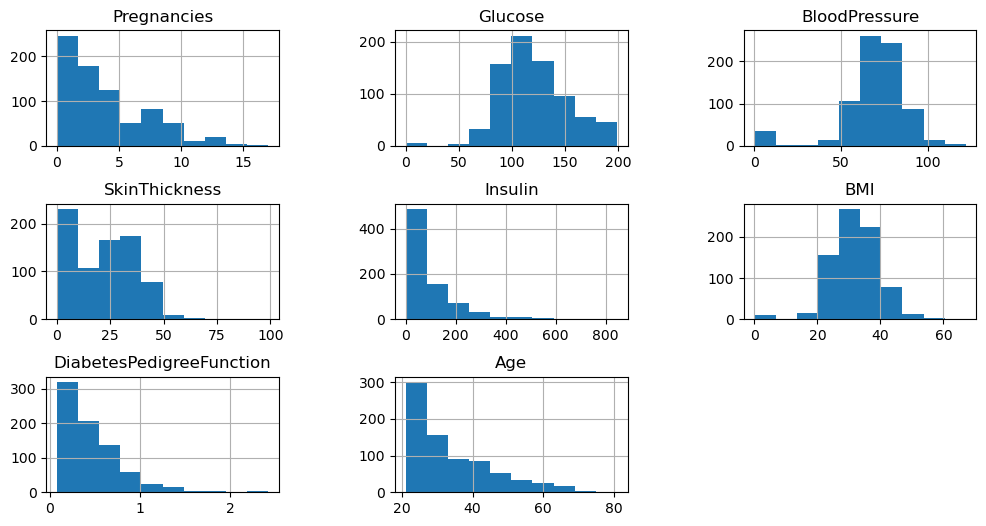

In [4]:
# Analyse unclean data distribution

#load data
data_unclean = pd.read_csv('diabetes-data-set/diabetes.csv')

print(data_unclean.isin([0]).sum())

# plot histograms
plot_histograms(data_unclean)

### We can see the Glucose, Bloodpressure, and BMI feaures have a more normal distribution than the other features. Usually we would replace any missing values with the MEAN but we know the MEAN is sensitive to outliers so we will first need to analyse if there are any outliers.

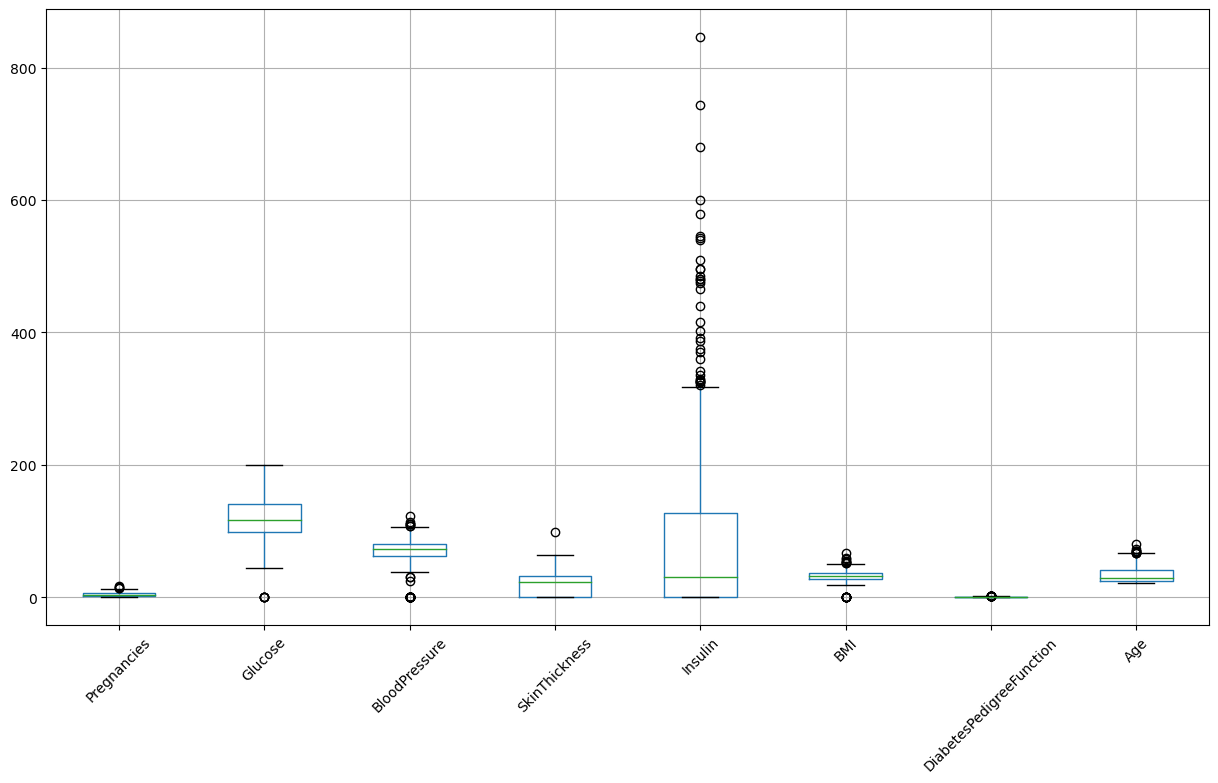

In [5]:
# Create box plots to identify outliers (if any)
plot_box_plots(data_unclean)

### We can clearly see that some of the features have outliers. We need to replace these values using the median because the median is less sensitive to outliers compared to the mean. This means that the median still has sort of a central tendency of the data.

## We now look at the cleaned data...

/tmp/ipykernel_4766/3628930817.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_to_plot.hist(ax=axs[0])


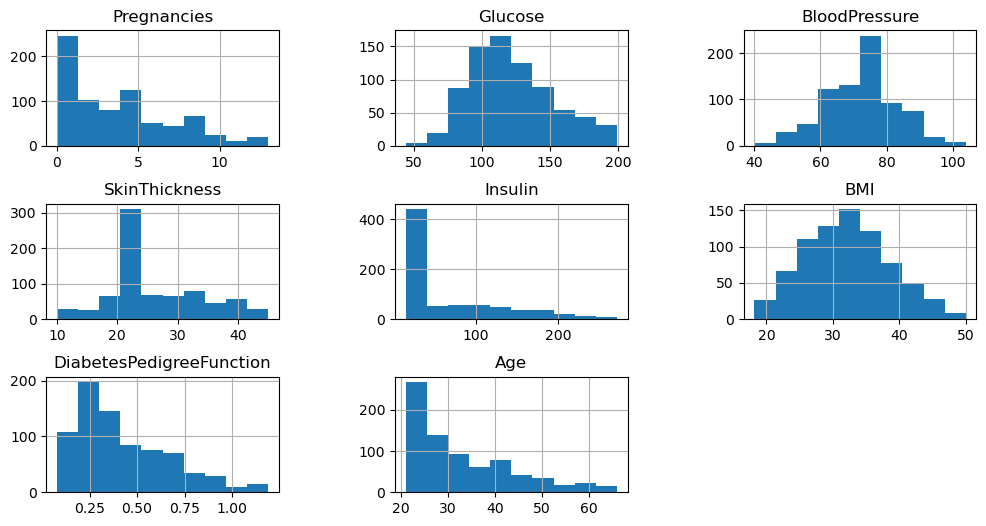

In [6]:
data_clean = clean_data(data_unclean)
plot_histograms(data_clean)

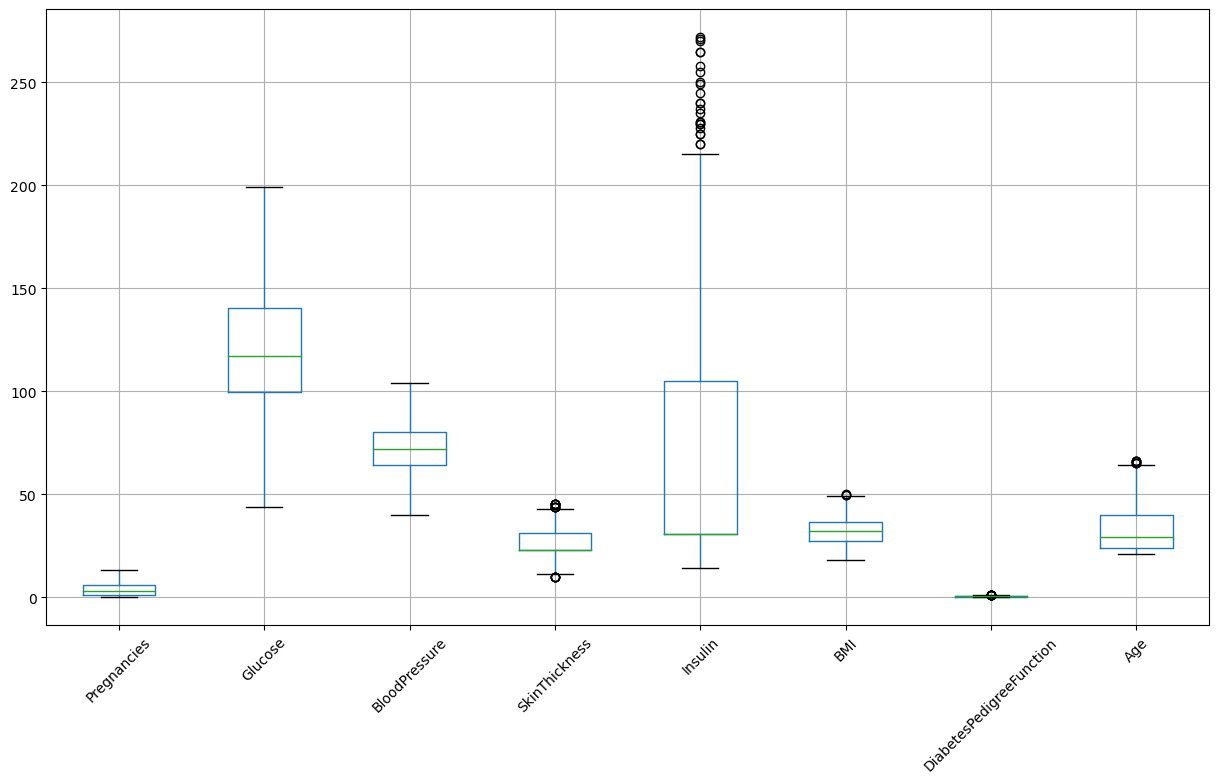

In [7]:
plot_box_plots(data_clean)

### Now we see that the data is cleaned of any outliers.

# ============= Code needed for main program =============

In [8]:
# Colours Class
class bcolors:
    ANSI_RESET = "\u001B[0m"
    ANSI_RED = "\u001B[31m"
    ANSI_GREEN = "\u001B[32m"
    ANSI_YELLOW = "\u001B[33m"
    ANSI_BLUE = "\u001B[34m"
    ANSI_PURPLE = "\u001B[35m"
    ANSI_CYAN = "\u001B[36m"
    ANSI_WHITE = "\u001B[37m"
    ANSI_BLACK = "\u001B[30m"
    ANSI_BOLD = '\033[1m'
    
# Node Class
class Node:
    def __init__(self, feature, threshold, left, right, at_depth, data=None, data_labels=None, parent=None, label=None):
        self.feature = feature  # Feature used for splitting (if not a leaf)
        self.threshold = threshold  # Threshold value for split (if not a leaf)
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.at_depth = at_depth
        self.label = label  # Predicted class label (for leaf nodes)
        self.parent = None # Keep reference of the parent for crossover purposes
        self.data = data
        self.data_labels = data_labels
    
    def get_all_nodes(self):
        nodes = [self]
        if self.left:
            nodes.extend(self.left.get_all_nodes())
        if self.right:
            nodes.extend(self.right.get_all_nodes())
        return nodes
    
    def copy(self):
        left_child = None
        right_child = None
        
        if self.left:
            left_child = self.left.copy()
        if self.right:
            right_child = self.right.copy()
        new_node = Node(self.feature, self.threshold, left_child, right_child, self.at_depth, self.data, self.data_labels, None, self.label)
        
        if new_node.left is not None:
            left_child.parent = new_node
            
        if new_node.right is not None:
            right_child.parent = new_node
            
        return new_node
    
    def replace_subtree(self, current_node, new_subtree):
        if self.left == current_node:
            self.left = new_subtree
        elif self.right == current_node:
            self.right = new_subtree
        new_subtree.parent = self
        
    def is_leaf(self):
        return self.label != None

class ProgressBar:
    def __init__(self, total_steps):
        self.total_steps = total_steps
        self.current_step = 0

    def increment(self):
        self.current_step += 1
        # Optionally, print a message here based on progress

    def get_progress(self):
        return self.current_step / self.total_steps

In [9]:
# def print_tree(tree_array, indent=" ", prefix="|---", index=0):
#     if index < len(tree_array):
#         return
    
#     if tree_array[index] is None:
#         return
    
#     if tree_array[index].label is not None:
#         print(f"{indent}{prefix} Leaf: {tree_array[index].label}")
#         return

#     print(f"{indent}{prefix} {tree_array[index].feature} <= {tree_array[index].threshold}")
#     new_indent = indent + "  "
#     print_tree(tree_array, new_indent, "L---", index*2+1)
#     print_tree(tree_array, new_indent, "R---", index*2+2)
def print_tree(node, indent=" ", prefix="|---"):
    if node is None:
        return
    
    if node.label is not None:
        print(f"{indent}{prefix} Leaf: {node.label} -- depth={node.at_depth}")
        return

    print(f"{indent}{prefix} {node.feature} <= {node.threshold} -- depth={node.at_depth}")
    new_indent = indent + "  "
    print_tree(node.left, new_indent, "L---")
    print_tree(node.right, new_indent, "R---")
    
# def write_tree(tree_array, file, indent=" ", prefix="|---", index=0):
#     if tree_array[index] is None:
#         return
    
#     if tree_array[index].label is not None:
#         file.write(f"{indent}{prefix} Leaf: {tree_array[index].label}\n")
#         return

#     file.write(f"{indent}{prefix} {tree_array[index].feature} <= {tree_array[index].threshold}\n")
#     new_indent = indent + "  "
#     write_tree(tree_array, file, new_indent, "L---", index*2+1)
#     write_tree(tree_array, file, new_indent, "R---", index*2+2)

def write_tree(node, file, indent=" ", prefix="|---"):
    if node is None:
        return
    
    if node.label is not None:
        file.write(f"\n{indent}{prefix} Leaf: {node.label}")
        return

    file.write(f"\n{indent}{prefix} {node.feature} <= {node.threshold}")
    new_indent = indent + "  "
    write_tree(node.left, file, new_indent, "L---")
    write_tree(node.right, file, new_indent, "R---")
    
def record_tree(file, f1_score, accuracy, precision, recall, tree, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed):
    f = open(file, "a+")
    f.write("\nSeed=" + str(seed))
    f.write("\nMaxDepth="  + str(max_depth))
    f.write("\nPop_depth=" + str(population_depth))
    f.write("\nPop_size=" + str(population_size))
    f.write("\nGenerations=" + str(generations))
    f.write("\nTourney_size=" + str(tourney_size))
    f.write("\nMutation_rate=" + str(mutation_rate))
    f.write("\nCrossover_rate=" + str(crossover_rate))
    f.write("\nF1-score=" + str(f1_score))
    f.write("\nAccuracy=" + str(accuracy))
    f.write("\nPrecision=" + str(precision))
    f.write("\nRecall=" + str(recall))
    f.write("\nTree=")
    write_tree(tree, f)
    f.close()
    
def train_test_split(data, seed, split_ratio=0.8):
    # Shuffle the data randomly
    data = data.sample(frac=1, random_state=seed)
    
    # Calculate the split index based on the split ratio
    split_index = int(len(data) * split_ratio)
    
    # Split the data into training and testing sets
    training_data = data[:split_index]
    testing_data = data[split_index:]
    
    return training_data, testing_data

In [10]:
#     return tree_array
def generate_individual(seed, X_train, features, existing_labels, max_depth):
    random.seed(seed)
    return generate_random_tree(X_train, features, existing_labels, max_depth)

def generate_random_tree(data, features, existing_labels, population_depth=3, current_depth=0): 
    # Check if any feature has values left
    available_features = [feature for feature in features if np.any(data[:, features.index(feature)])]
    if not available_features:
        # If no features have values left, return a leaf node
#         print('========== features empty ==========')
        label = random.choice([0,1])
        return Node(None, None, None, None, current_depth, label=label) # we only add a label since it is a leaf node

    # Choose a random feature from available options
    feature = random.choice(features)

    # Generate a random threshold based on the chosen feature's values
    feature_values = data[:, features.index(feature)]
    threshold = random.uniform(np.min(feature_values), np.max(feature_values))

    # Split data based on the chosen feature and threshold
    left_data, right_data, left_labels, right_labels = split_data(data, features, existing_labels, feature, threshold)
    
    # Check if we can traverse deeper or not
    if current_depth >= population_depth:
        # Generate leaf node
        label = random.choice([0,1])
        return Node(None, None, None, None, current_depth, label=label) # we only add a label since it is a leaf node
    
    # check if we should randomly generate a tree with depth = max_depth - 2
#     if random.random() < 0.25:
#         left_child = Node(None, None, None, None, current_depth+1, label=random.choice([0,1]))
#         right_child = Node(None, None, None, None, current_depth+1, label=random.choice([0,1]))
#         node = Node(feature, threshold, left_child, right_child, current_depth)
        
#         # Set parent links
#         left_child.parent = node
#         right_child.parent = node
        
#         return node
    
    # Else traverse deeper
    # first go left  
    # Recursively generate child nodes
    left_child = generate_random_tree(left_data, features, left_labels, population_depth, current_depth + 1) # left child
    
    # Then go right
    right_child = generate_random_tree(right_data, features, right_labels, population_depth, current_depth + 1) # right child
    
    # Create a parent node
    node = Node(feature, threshold, left_child, right_child, current_depth, data, existing_labels)
    
    # Set parent links
    left_child.parent = node
    right_child.parent = node

    return node


def split_data(data, features, existing_labels, feature, threshold):
    # Split data into data left and right of the threshold value

    left_index = data[:, features.index(feature)] <= threshold
    right_index = ~left_index

    left_data = data[left_index]
    right_data = data[right_index]

    left_labels = existing_labels[left_index]
    right_labels = existing_labels[right_index]

    return left_data, right_data, left_labels, right_labels
            

<div style='text-align: center'><h1>========= Genetic Programming Functions ==========</h1></div>

In [11]:
#==============================
#======== GP Functions ========
#==============================
def evaluate_tree(node, X_train, Y_train, features, existing_labels):    
    correct_predictions = 0
    data_size = len(X_train)
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives

    # run through the training data
    for i in range(data_size):
        iterator_node = node.copy()
        instance = X_train.iloc[i, :]
        target_label = Y_train.iloc[i] 
        while not iterator_node.is_leaf():                
            if instance.get(iterator_node.feature) <= iterator_node.threshold:
                iterator_node = iterator_node.left
            else:
                iterator_node = iterator_node.right

        # get the predicted label
        predicted_label = iterator_node.label

        # Update counters based on prediction
        if predicted_label == target_label:
            correct_predictions += 1
            TP += 1
        else:
            if predicted_label == 1:
                FP += 1
            else:
                FN += 1 

    # Calculate accuracy as the fitness score
    accuracy = correct_predictions / data_size
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return [F1_score, accuracy, precision, recall]
    
def tournament_select(population, fitness_values, tourney_size):
    pop_size = len(population)
    random_indices = [random.randrange(0, pop_size) for _ in range(tourney_size)]
    curr_best_index = random_indices[0] # randomly select an index
    curr_best_fitness = fitness_values[curr_best_index][0] # select randomly selected fitness value - [0] for F1-score
    
    for i, candidate_index in enumerate(random_indices[:1]):
        candidate_fitness = fitness_values[candidate_index][0]
        
        # test if candidate is new winner
        if candidate_fitness > curr_best_fitness:
            # update best fitness candidate and the index
            curr_best_fitness = candidate_fitness 
            curr_best_index = candidate_index
    return population[curr_best_index]

def update_threshold(node, parent, X_train, labels, features):
    if node is None or node.is_leaf():
        return
    
    if parent is None:
        # Generate a random threshold based on the chosen feature's values
        feature_values = X_train[:, features.index(node.feature)]
        threshold = random.uniform(np.min(feature_values), np.max(feature_values))
        
        node.data = X_train
        node.data_labels = labels
        node.threshold = threshold
    
    #Else use parent node's data
    else:
        # first get left and right data according to parent's data
        left_data, right_data, left_labels, right_labels = split_data(parent.data, features, parent.data_labels, parent.feature, parent.threshold)

        # if either side array (left or right) is empty we create a leaf node
        if len(left_data) == 0 or len(right_data) == 0:
            label = random.choice([0,1])
            new_node = Node(None, None, None, None, node.at_depth, label=label)

            node.parent.replace_subtree(node, new_node)
            return
        # Else
        # test which child the current node is
        if node == parent.left:
            # Generate a random threshold based on the chosen feature's values
            feature_values = left_data[:, features.index(node.feature)]
            threshold = random.uniform(np.min(feature_values), np.max(feature_values))

            node.data = left_data
            node.data_labels = left_labels
            node.threshold = threshold
        elif node == parent.right:
            # Generate a random threshold based on the chosen feature's values
            feature_values = right_data[:, features.index(node.feature)]
            threshold = random.uniform(np.min(feature_values), np.max(feature_values))

            node.data = right_data
            node.data_labels = right_labels
            node.threshold = threshold

def update_depth(node, parent_depth, max_depth, X_train, labels, features):
    if node is None:
        return
    node.at_depth = parent_depth+1  # Update current node depth
    
    # We need to Prune the subtree if we reached max depth
    if node.at_depth == max_depth:
        # node should be leaf node instead
        label = random.choice([0,1])
        node.parent.replace_subtree(node, Node(None, None, None, None, max_depth, label=label))
        return
    
    # first update the node's threshold to still make sense according to the tree structure
    update_threshold(node, node.parent, X_train, labels, features)
    update_depth(node.left, node.at_depth, max_depth, X_train, labels, features)  # Update left subtree
    update_depth(node.right, node.at_depth, max_depth, X_train, labels, features)  # Update right subtree

def crossover(parent1, parent2, max_depth, X_train, labels, features):    
    # create two selection points; one for each parent
    crossover_point1 = random.choice(parent1.get_all_nodes())
    crossover_point2 = random.choice(parent2.get_all_nodes())
    
    p1_copy = parent1.copy()
    p2_copy = parent2.copy()
    cp1_copy = crossover_point1.copy()
    
    if crossover_point1.parent is not None:
        node = crossover_point2.copy()
        crossover_point1.parent.replace_subtree(crossover_point1, node)
        update_depth(node, crossover_point1.parent.at_depth, max_depth, X_train, labels, features)
    else:
        crossover_point1 = crossover_point2.copy()
        crossover_point1.parent = None
        update_depth(crossover_point1, -1, max_depth, X_train, labels, features)
    
    if crossover_point2.parent is not None:
#         node = cp1_copy.copy()
        crossover_point2.parent.replace_subtree(crossover_point2, cp1_copy)
        update_depth(cp1_copy, crossover_point2.parent.at_depth, max_depth, X_train, labels, features)
    else:
        crossover_point2 = crossover_point1.copy()
        crossover_point2.parent = None
        update_depth(crossover_point2, -1, max_depth, X_train, labels, features)

    return [p1_copy, p2_copy]

def mutate(tree, mutation_rate, data, features, max_depth, labels):
    mutated_tree = tree.copy()  # Make a copy of the tree to avoid modifying the original
    
    mutation_point = random.choice(mutated_tree.get_all_nodes())

    if mutation_point.at_depth == max_depth:
        mutation_point.label ^= 1 # Bitwise XOR operation to flip the label
        return mutated_tree
    else:
        # Remove node at mutation point with new subtree or a terminal node
        choice = random.choice([0,1])

        if choice:
            # create new subtree        
            # Choose a random feature from available options
            feature = random.choice(features)

            # Generate a random threshold based on the chosen feature's values
            if mutation_point.parent is not None and len(mutation_point.parent.data) > 0:
                feature_values = mutation_point.parent.data[:, features.index(feature)]
            else:
                feature_values = data[:, features.index(feature)]
            threshold = random.uniform(np.min(feature_values), np.max(feature_values))

            # Create child leaf nodes
            label = random.choice([0,1])
            left_child = Node(None, None, None, None, mutation_point.at_depth+1, label=label)

            label = random.choice([0,1])
            right_child = Node(None, None, None, None, mutation_point.at_depth+1, label=label)

            # Create a parent node
            node = Node(feature, threshold, left_child, right_child, mutation_point.at_depth, data, labels)

            left_child.parent = node
            right_child.parent = node
            
            if mutation_point.parent is not None:
                mutation_point.parent.replace_subtree(mutation_point, node)
            else:
                mutation_point = node
                
            # update the threshold value
            update_threshold(mutation_point, mutation_point.parent, data, labels, features)
            
        else:
            label = random.choice([0,1])
            node = Node(None, None, None, None, mutation_point.at_depth, label=label)
            
            if mutation_point.parent is not None:
                mutation_point.parent.replace_subtree(mutation_point, node)
            else:
                mutation_point = node

            mutation_point = node

    return mutated_tree

def build_individual(g, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, existing_labels, features, max_depth):    
    # Select parents
    parent_one = tournament_select(initial_population, fitness_values, tourney_size)
    parent_two = tournament_select(initial_population, fitness_values, tourney_size)

    # Perform crossover or copy parents
    if random.random() < crossover_rate:
        offsprings = crossover(parent_one, parent_two, max_depth, X_train.values, existing_labels, features)
    else:
        p1_index = initial_population.index(parent_one)
        p2_index = initial_population.index(parent_two)
        offsprings = [parent_one.copy()] if fitness_values[p1_index] > fitness_values[p2_index] else [parent_two.copy()]

    # Apply mutation
    if random.random() < mutation_rate:
        for i, offspring in enumerate(offsprings):
            offsprings[i] = mutate(offspring, mutation_rate, X_train.values, features, max_depth, existing_labels)

    # Choose best offspring (if applicable)
    if len(offsprings) >= 2:
        offspring_fitness = [evaluate_tree(T, X_train, Y_train, features, existing_labels)[0] for T in offsprings]
        best_offspring_index = offspring_fitness.index(max(offspring_fitness))
            
        return offsprings[best_offspring_index]
    else:
        return offsprings[0]

def evolve_population(g, s, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, existing_labels, features, max_depth):
    random.seed(s)
    return build_individual(g, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, existing_labels, features, max_depth)
            
def evolve_DT(X_train, Y_train, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed):
    # ensure we are using a fixed global seed
    random.seed(seed)
    
    features = list(X_train.columns[:])
    existing_labels = Y_train.values  
    
    build_start_time = time.time()
    # Create pool of processes
    with multiprocessing.Pool(8) as pool:
        # Generate initial population in parallel
        seeds = [random.randint(1, population_size+(population_size//2)) for _ in range(population_size)]
        print("Seed values used for initial population:", seeds)
        args = [(s, X_train.values, features, existing_labels, population_depth) for s in seeds]
        initial_population = pool.starmap(generate_individual, args)
    pool.join()
    build_end_time = time.time()
    print(f"{bcolors.ANSI_CYAN}Initial population generation elapsed time {build_end_time - build_start_time}{bcolors.ANSI_RESET}")
    fitness_values = [0 for _ in range(population_size)]
    tree_generations = []
    fitness_generations = []
    last_10_fitness = []
    
    all_gen_avg_f1_score = []
    all_gen_avg_accuracy = []
    all_gen_avg_precision = []
    all_gen_avg_recall = []
    
    best_f1_score = 0
    best_accuracy = 0
    best_precision = 0
    best_recall = 0
    
    all_gen_run_times = []
    
    # iterate for the number of generations and population size
    for g in range(generations):
        bar_length = 20
        # Print generation accuracy
        print(bcolors.ANSI_RESET)
        print(f"{bcolors.ANSI_BOLD}====================================================================================")
        print(f"Generation: {g + 1}")

        # Create pool of processes
        evaluate_time = time.time()
        with multiprocessing.Pool(8) as pool:
            # Evaluate fitness of each individual in parallel
            args = [(individual, X_train, Y_train, features, existing_labels) for individual in initial_population]
            fitness_values = pool.starmap(evaluate_tree, args)
        pool.join()
        evaluated_time = time.time()
        print(f"{bcolors.ANSI_CYAN}Time to evaluate population: {evaluated_time - evaluate_time}{bcolors.ANSI_RESET}")
        
        # Extract results
        f1_scores = [f1score_accuracy[0] for f1score_accuracy in fitness_values]
        accuracy_scores = [f1score_accuracy[1] for f1score_accuracy in fitness_values]
        precision_scores = [f1score_accuracy[2] for f1score_accuracy in fitness_values]
        recall_scores = [f1score_accuracy[3] for f1score_accuracy in fitness_values]
        
        # Store results
        all_gen_avg_f1_score.append(np.mean(f1_scores)) # Average f1-score of each generation will be stored
        all_gen_avg_accuracy.append(np.mean(accuracy_scores)) # Average accuracy of each generation will be stored
        all_gen_avg_precision.append(np.mean(precision_scores)) # Average precision of each generation will be stored
        all_gen_avg_recall.append(np.mean(recall_scores)) # Average recall of each generation will be stored
            
        # Find the best individual
        best_fitness = max(accuracy_scores)
        result_index = accuracy_scores.index(best_fitness)
        best_index = fitness_values.index([f1_scores[result_index], best_fitness, precision_scores[result_index], recall_scores[result_index]])
        best_individual = initial_population[best_index]
        
        print(f"{bcolors.ANSI_BOLD}{bcolors.ANSI_YELLOW}Average Accuracy: {np.mean(accuracy_scores)}") 
        print(f"{bcolors.ANSI_GREEN}Best Accuracy: {best_fitness}{bcolors.ANSI_RESET}")
        print(f"{bcolors.ANSI_GREEN}F-measure: {f1_scores[result_index]}")
        print(f"{bcolors.ANSI_GREEN}Precision: {precision_scores[result_index]}")
        print(f"{bcolors.ANSI_GREEN}Recall: {recall_scores[result_index]}{bcolors.ANSI_RESET}")
#         print(f"Population Accuracies:\n {accuracy_scores}")
        
        last_10_fitness.append(np.mean(accuracy_scores))
        
        tree_generations.append(best_individual)
        fitness_generations.append([f1_scores[result_index], best_fitness, precision_scores[result_index], recall_scores[result_index]])
        
        if len(last_10_fitness) == 10:
            # if the last 10 generations did not increase by at least 5% on average we stop
            biggest_increase = 0
            for i in range(9):
                increase_percentage = round((last_10_fitness[i + 1] - last_10_fitness[i]) / last_10_fitness[i] * 100, 2)
                if increase_percentage > biggest_increase:
                    biggest_increase = increase_percentage

            if biggest_increase < 1:
                # Stop condition
                all_gen_run_times.append(0.0) # indicates the generation did not finish
                print(f"\n{bcolors.ANSI_BOLD}{bcolors.ANSI_RED}Too few increase in accuracy. Stopping condition met{bcolors.ANSI_RESET}") 
                break
                
            # shift array left
            last_10_fitness.pop(0) # remove oldest element
        
        # if we somehow found 100% accuracy, stop the process
        if best_fitness == 1.0:
            all_gen_run_times.append(0.0) # indicates the generation did not finish
            return best_individual 
        
        new_population = [best_individual.copy()]
        completed = 1

        # Run through population and do selection, crossover, and mutation 
        starttime = time.time()
     
        # Create new seed values
        seed_vals = [random.randint(1, population_size+(population_size//2)) for _ in range(population_size)]
        
        with multiprocessing.Pool(8) as pool:
            # Prepare arguments for each individual
            args = [(g, s, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, existing_labels, features, max_depth) for s in seed_vals]
            evolved_pop = pool.starmap(evolve_population, args)

        pool.join() # Wait for processes to finish
        
        endtime = time.time()
        new_population.extend(evolved_pop) 
        
        # Store run time of generation
        all_gen_run_times.append(endtime-starttime)
        
        print(f"\n{bcolors.ANSI_BOLD}Elapsed: {bcolors.ANSI_PURPLE}{endtime-starttime}") # print new line
        print(bcolors.ANSI_RESET + bcolors.ANSI_BOLD + "====================================================================================" + bcolors.ANSI_RESET)
        
        # Update population
        initial_population = new_population
        
    # print the best generation tree to a file if it did well enough
    gen_f1_scores = [results[0] for results in fitness_generations]
    gen_accuracy_scores = [results[1] for results in fitness_generations]
    gen_precision_scores = [results[2] for results in fitness_generations]
    gen_recall_scores = [results[3] for results in fitness_generations]
    
    best_gen_fitness = max(gen_accuracy_scores)
    result_index = gen_accuracy_scores.index(best_gen_fitness)
    best_gen_index = fitness_generations.index([gen_f1_scores[result_index], best_gen_fitness, gen_precision_scores[result_index], gen_recall_scores[result_index]])
    best_tree = tree_generations[best_gen_index]
    
    best_results = [gen_f1_scores[result_index], best_gen_fitness, gen_precision_scores[result_index], gen_recall_scores[result_index]]
    generation_results_averages = [all_gen_avg_f1_score, all_gen_avg_accuracy, all_gen_avg_precision, all_gen_avg_recall]
    
    if gen_accuracy_scores[result_index] > 0.85:
        file = "generation_records.txt"
        record_tree(file, gen_f1_scores[result_index], best_gen_fitness, gen_precision_scores[result_index], gen_recall_scores[result_index], best_tree, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed)
    return best_tree, best_results, generation_results_averages, all_gen_run_times

<div style='text-align:center'><h1>========= Main Program ==========</h1></div>


Select an option:
1) Train Decision Tree
2) Test Decision Tree
3) Quit
1
Seed value: 846525
Max depth: 5
Population depth: 4
Population size: 500
Generations: 30
Tournament size: 5
Mutation rate: 0.2
Crossover rate: 0.9
Combination: Seed=846525, Max Depth=5, Population Depth=4, Population Size=500, Generations=30, Tourney Size=5, Mutation Rate=0.2, Crossover Rate=0.9
Seed values used for initial population: [466, 347, 500, 498, 741, 431, 519, 173, 161, 519, 255, 623, 100, 726, 349, 494, 704, 276, 716, 290, 198, 513, 455, 284, 509, 379, 26, 219, 629, 517, 435, 172, 571, 105, 620, 388, 561, 228, 37, 31, 502, 39, 497, 493, 151, 668, 637, 13, 552, 305, 384, 329, 208, 26, 250, 345, 331, 301, 582, 232, 175, 59, 407, 392, 483, 3, 446, 456, 135, 711, 346, 511, 662, 719, 520, 590, 188, 295, 9, 129, 188, 682, 241, 699, 207, 275, 555, 277, 374, 142, 400, 513, 68, 152, 536, 403, 116, 371, 579, 615, 51, 478, 169, 89, 151, 102, 511, 425, 285, 60, 99, 372, 402, 31, 253, 634, 138, 7, 748, 531, 551, 1


Elapsed: 23.756431818008423

Generation: 12
Time to evaluate population: 10.025657653808594
Average Accuracy: 0.7296414116212019
Best Accuracy: 0.7569444444444444
F-measure: 0.8616600790513833
Precision: 0.8667992047713717
Recall: 0.8565815324165029

Elapsed: 21.388281106948853

Generation: 13
Time to evaluate population: 9.498392820358276
Average Accuracy: 0.7348532102461742
Best Accuracy: 0.7586805555555556
F-measure: 0.8627838104639685
Precision: 0.8619329388560157
Recall: 0.8636363636363636

Elapsed: 21.132771968841553

Generation: 14
Time to evaluate population: 9.09034538269043
Average Accuracy: 0.7396942226657796
Best Accuracy: 0.7586805555555556
F-measure: 0.8627838104639685
Precision: 0.8619329388560157
Recall: 0.8636363636363636

Elapsed: 19.932322025299072

Generation: 15
Time to evaluate population: 8.85465407371521
Average Accuracy: 0.7439080172987358
Best Accuracy: 0.7586805555555556
F-measure: 0.8627838104639685
Precision: 0.8619329388560157
Recall: 0.8636363636363636



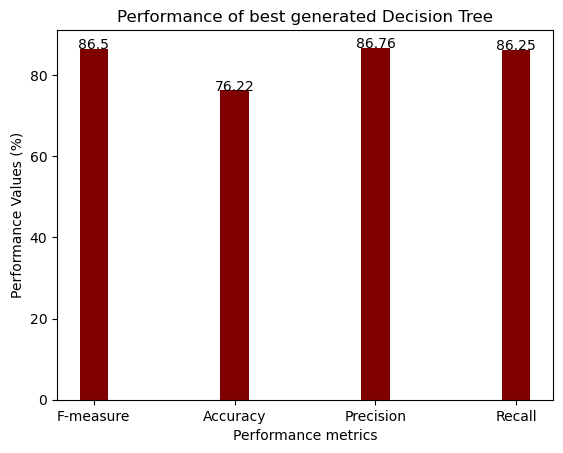

Average performance values for all generations


,Gen Label,Avg F-measure (%),Avg Accuracy (%),Avg Precision (%),Avg Recall (%),Run Time (seconds)
0,Generation 1,0.664940,0.506135,0.632500,0.760625,23.136600
1,Generation 2,0.722537,0.570737,0.738359,0.739528,23.987900
2,Generation 3,0.761227,0.617283,0.821377,0.728049,23.510200
3,Generation 4,0.786895,0.649784,0.878322,0.722750,23.561200
4,Generation 5,0.799171,0.666282,0.902186,0.725635,23.706500
5,Generation 6,0.809886,0.680888,0.904510,0.739060,23.556500
6,Generation 7,0.816687,0.690480,0.903364,0.750591,23.365000
7,Generation 8,0.824119,0.701087,0.898582,0.765865,23.083100
8,Generation 9,0.829109,0.708295,0.884713,0.784336,24.128400
9,Generation 10,0.834437,0.716047,0.871011,0.804400,23.624400



Select an option:
1) Train Decision Tree
2) Test Decision Tree
3) Quit
2
Seed value: 846525
Testing tree...
F1-score -  0.8537313432835821 	Accuracy -  74.47916666666666


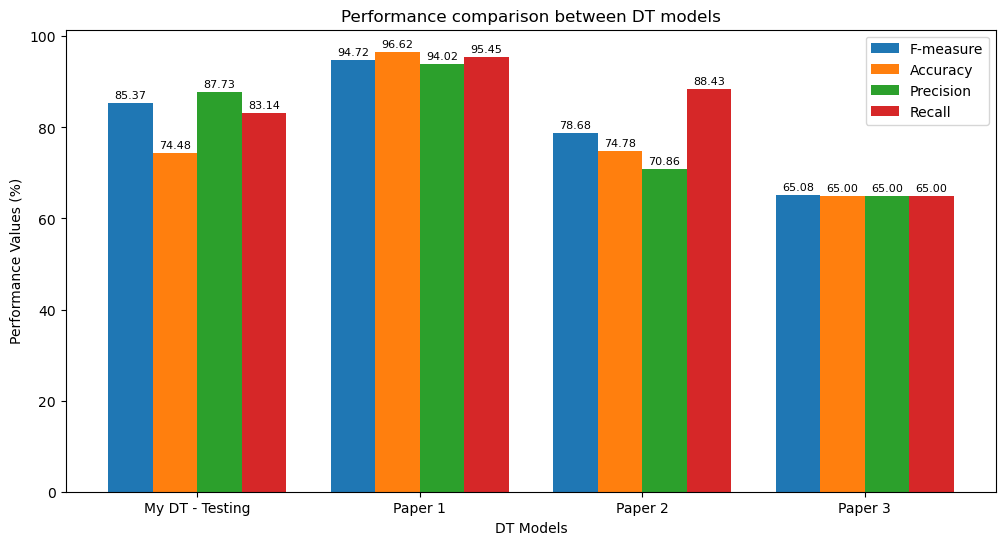


Select an option:
1) Train Decision Tree
2) Test Decision Tree
3) Quit
3


In [12]:
### ===========================================
# ============ main program =================
# ===========================================
import os
# seed = 84651923
# seed = 5
# random.seed(seed)
# # Clean the data
# data_clean = clean_data(data_unclean)

# ========= CLEANING DONE ============

# Split data into training and testing
# training_data, testing_data = train_test_split(data_clean, seed, split_ratio=0.8)

# X_train = training_data.iloc[:,:-1]
# Y_train = training_data.iloc[:,-1]

# # print(X_train)

# X_test = testing_data.iloc[:, :-1]
# Y_test = testing_data.iloc[:,-1]

# ========= SPLITTING DONE ===========

# Build the Decision Tree
# max_depth = 5
# population_depth = 3
# population_size = 10
# generations = 1
# tourney_size = 5
# mutation_rate = 0.3
# crossover_rate = 0.8

# instance = X_train.iloc[0, :]
# print(instance.get("Age"))
# tree = evolve_DT(X_train, Y_train, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed)
# features = list(X_train.columns[:-1])
# existing_labels = Y_train.values
# node1 = generate_individual(846589, X_train.values, features, existing_labels, 4)
# node2 = generate_individual(849, X_train.values, features, existing_labels, 4)
# nodes = [node1, node2]
# offspring_fitness = [evaluate_tree(T, X_train, Y_train, features, existing_labels) for T in nodes] # we want f1-score
# print(offspring_fitness)
# offspring_fitness = [evaluate_tree(T, X_train, Y_train, features, existing_labels) for T in nodes][0] # we want f1-score
# best_offspring_index = offspring_fitness.index(max(offspring_fitness))
# new_offspring = nodes[best_offspring_index]
# print(offspring_fitness)
# offspring_fitness = [evaluate_tree(T, X_train, Y_train, features, existing_labels)[0] for T in nodes] # we want f1-score
# best_offspring_index = offspring_fitness.index(max(offspring_fitness))
# new_offspring = nodes[best_offspring_index]
# print(offspring_fitness)
# fitness = evaluate_tree(node, X_train, Y_train, features, existing_labels)
# f1_score = fitness[0]
# accuracy = fitness[1]
# print(f1_score, " ", accuracy)
# print_tree(node)

# file = "generation_records.txt"
# record_tree(file, f1_score, accuracy, node, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed)

# Generate random tree
# features = list(data_clean.columns[:-1])
# existing_labels = data_clean.iloc[:, -1].values
# node = generate_random_tree(data_clean.values, features, existing_labels, max_depth)
# print_tree(node)
# print("Accuracy: ", evaluate_tree(node, X_train, Y_train, features, existing_labels))
# print(X_train.columns[:-1])

# Define functions for highlighting
def highlight_max(s):
    """Highlight the maximum value in a Series."""
    is_max = (s == s.max())
    return ['background: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    """Highlight the minimum value in a Series."""
    is_min = (s == s.min())
    return ['background-color: red' if v else '' for v in is_min]

def highlight_max_runtime(s):
    """Highlight the maximum value in the "Run Time" column."""
    is_max = (s == s.max())
    return ['background-color: red' if v else '' for v in is_max]

def highlight_min_runtime(s):
    """Highlight the minimum value in the "Run Time" column."""
    is_min = (s == s.min()) & (s != 0.0)
    return ['background: lightgreen' if v else '' for v in is_min]


# Define the ranges for each parameter
max_depth_values = [5, 6, 7]
population_depth_ranges = {5: range(3, 5), 6: range(4, 6), 7: range(5, 7)}
population_size_values = range(90, 100)
generations_values = range(150, 200)
tourney_size_values = range(2, 3)
mutation_rate_values = np.arange(0.001, 0.01, 0.025)
crossover_rate_values = np.arange(0.8, 0.95, 0.025)
tree = None

# Store the results of Papers 1, 2, and 3:
paper1_f1, paper1_accuracy, paper1_precision, paper1_recall = 94.72, 96.62, 94.02, 95.45
paper2_f1, paper2_accuracy, paper2_precision, paper2_recall = 78.68, 74.78, 70.86, 88.43
paper3_f1, paper3_accuracy, paper3_precision, paper3_recall = 65.08, 65.0, 65.0, 65.0

while True:
    user_input = input('\nSelect an option:\n1) Train Decision Tree\n2) Test Decision Tree\n3) Quit\n')
    
    if user_input == "3":
        break
        
    seed = input('Seed value: ')
    while True:
        if seed.isnumeric() == True:
            seed = int(seed)
            break
        print('Invalid seed. Select a valid seed.')
    random.seed(seed)

    # Clean the data
#     data_clean = clean_data(data_unclean)

    # ========= CLEANING DONE ============

    # Split data into training and testing
    training_data, testing_data = train_test_split(data_clean, seed, split_ratio=0.75)

    X_train = training_data.iloc[:,:-1]
    Y_train = training_data.iloc[:,-1]

    X_test = testing_data.iloc[:, :-1]
    Y_test = testing_data.iloc[:,-1]
    
    if user_input == "1":
        # Clear the output of the cell
#         clear_output(wait=True)
        
        # Number of random combinations to test
        num_combinations = 5

        max_depth = int(input("Max depth: "))
        population_depth = int(input("Population depth: "))
        population_size = int(input("Population size: "))
        generations = int(input("Generations: "))
        tourney_size = int(input("Tournament size: "))
        mutation_rate = float(input("Mutation rate: "))
        crossover_rate = float(input("Crossover rate: "))

        # Your code for testing the parameters goes here
        print(f"Combination: Seed={seed}, Max Depth={max_depth}, Population Depth={population_depth}, Population Size={population_size}, Generations={generations}, Tourney Size={tourney_size}, Mutation Rate={mutation_rate}, Crossover Rate={crossover_rate}")

        starttime = time.time()
        tree, best_gen_results, gen_averages, gen_run_times = evolve_DT(X_train, Y_train, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed)
        endtime = time.time()
        print("Elapsed Generations: ", endtime-starttime)

        # plot all the best results for my algorithm and Papers 1,2, and 3:
        my_results = [round(value*100,2) for value in best_gen_results]
        rounded_run_times = [round(t, 4) for t in gen_run_times]
        
        x_labels = ['F-measure', 'Accuracy', 'Precision', 'Recall']
        
        X_axis = np.arange(len(x_labels))
        
        bar_width = 0.2
        plt.bar(x_labels, my_results, width=bar_width, color="maroon")
        
        for i in range(len(x_labels)):
            plt.text(i, my_results[i], my_results[i], ha = 'center')

        plt.xticks(X_axis, x_labels) 
        plt.xlabel("Performance metrics") 
        plt.ylabel("Performance Values (%)") 
        plt.title("Performance of best generated Decision Tree") 
        plt.show() 
        
        # Create a DataFrame to store each generations performance
        avg_f1_scores = gen_averages[0]
        avg_accuracy = gen_averages[1]
        avg_precision = gen_averages[2]
        avg_recall = gen_averages[3]
        
        gen_labels = ["Generation " + str(i+1) for i in range(len(avg_f1_scores))]
        
        dict = {"Gen Label": gen_labels,
                "Avg F-measure (%)": avg_f1_scores,
                "Avg Accuracy (%)": avg_accuracy,
                "Avg Precision (%)": avg_precision,
                "Avg Recall (%)": avg_recall,
                "Run Time (seconds)": rounded_run_times}
        
        df = pd.DataFrame(dict)
        print(f"{bcolors.ANSI_BOLD}Average performance values for all generations")
        
        # Apply highlighting
        styled_df = df.style.apply(highlight_max, subset=df.columns[1:-1]) \
                      .apply(highlight_min, subset=df.columns[1:-1]) \
                      .apply(highlight_min_runtime, subset=["Run Time (seconds)"]) \
                      .apply(highlight_max_runtime, subset=["Run Time (seconds)"])

        # Display the styled DataFrame
        display(styled_df)
    elif user_input == "2":
        print('Testing tree...')
        features = list(X_train.columns[:])
        existing_labels = Y_train.values
        fitnesses = evaluate_tree(tree, X_test, Y_test, features, existing_labels)
        my_results = [round(value*100,2) for value in fitnesses]
        print("F1-score - ", fitnesses[0], "\tAccuracy - ", fitnesses[1]*100)
        
        x_labels = ['My DT - Testing', 'Paper 1', 'Paper 2', 'Paper 3']
        f_scores = [my_results[0], paper1_f1, paper2_f1, paper3_f1]
        accuracy_scores = [my_results[1], paper1_accuracy, paper2_accuracy, paper3_accuracy]
        precision_scores = [my_results[2], paper1_precision, paper2_precision, paper3_precision]
        recall_scores = [my_results[3], paper1_recall, paper2_recall, paper3_recall]
        
        X_axis = np.arange(len(x_labels))
        
        bar_width = 0.2
        plt.figure(figsize=(12, 6))  # Set the figure size to 12x6 inches
        plt.bar(X_axis - 1.5*bar_width, f_scores, width=bar_width, label='F-measure')
        plt.bar(X_axis - 0.5*bar_width, accuracy_scores, width=bar_width, label='Accuracy')
        plt.bar(X_axis + 0.5*bar_width, precision_scores, width=bar_width, label='Precision')
        plt.bar(X_axis + 1.5*bar_width, recall_scores, width=bar_width, label='Recall')
        
        for i in range(len(x_labels)):
            plt.text(X_axis[i] - 1.5*bar_width, f_scores[i]+1, f"{f_scores[i]:.2f}", ha='center', fontsize=8)
            plt.text(X_axis[i] - 0.5*bar_width, accuracy_scores[i]+1, f"{accuracy_scores[i]:.2f}", ha='center', fontsize=8)
            plt.text(X_axis[i] + 0.5*bar_width, precision_scores[i]+1, f"{precision_scores[i]:.2f}", ha='center', fontsize=8)
            plt.text(X_axis[i] + 1.5*bar_width, recall_scores[i]+1, f"{recall_scores[i]:.2f}", ha='center', fontsize=8)


        plt.xticks(X_axis, x_labels) 
        plt.xlabel("DT Models") 
        plt.ylabel("Performance Values (%)") 
        plt.title("Performance comparison between DT models") 
        plt.legend() 
        plt.show()
    else:
        print('Invalid option. Try again.')
# seed = 14325